In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
import nltk
from IPython.display import Image
import datetime
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.decomposition import NMF
from scipy import stats
from sklearn.metrics import explained_variance_score
from pylab import rcParams
from collections import Counter
import scipy as sp
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import networkx as nx
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import networkx as nx
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import fisher_exact

In [2]:
#CI helpers

def lower_error(data):
	nbr_draws = 1000
	means = np.zeros(nbr_draws)
	data = np.array(data)

	for n in range(nbr_draws):
		indices = np.random.randint(0, len(data), len(data))
		data_tmp = data[indices] 
		means[n] = np.nanmean(data_tmp)

	return np.nanpercentile(means, 2.5)

def upper_error(data):
	nbr_draws = 1000
	means = np.zeros(nbr_draws)
	data = np.array(data)

	for n in range(nbr_draws):
	    indices = np.random.randint(0, len(data), len(data))
	    data_tmp = data[indices] 
	    means[n] = np.nanmean(data_tmp)

	return np.nanpercentile(means, 97.5)

In [3]:
pairs = pd.read_pickle('new_pairs_all_rests')

df_pairs_frequencies = pd.DataFrame(pd.Series(pairs.index).apply(lambda x: x.split(' ')))
df_pairs_frequencies['frequency'] = pairs.values

cohort = df_pairs_frequencies.loc[(df_pairs_frequencies['frequency']>= 10)].copy() 

cohort.columns = ['pair','frequency']

tmp = cohort['frequency'].values

Ns = []
for i in tmp:
    Ns.extend([i, i])

df_participants = pd.read_pickle("df_focal_persons.pkl")
#isolate those who have a single eating partner
df_participants['N'] = Ns
df_participants_single = df_participants.groupby("ID").filter(lambda x: len(x) == 1)

In [4]:
import ast
with open('matched_persons.txt','r') as f:
    matching = ast.literal_eval(f.read())

## Pooled analyses of the outcome

### a) regression modelling

In [5]:
matched_treated_high = []
matched_treated_low = []

for i in matching:
    if str(i[1])[0] == 't':
        matched_treated_high.append(str(i[1])[1:])
        matched_treated_low.append(str(i[0])[1:])
    else:
        matched_treated_low.append(str(i[1])[1:])
        matched_treated_high.append(str(i[0])[1:])


diff = []
Ns_c = []
Ns_t = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+7]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+7]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns_t.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
    Ns_c.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["N"].iloc[0])

In [6]:
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

In [7]:
Y = t_post + c_post

In [8]:
df_X_h = pd.DataFrame()

df_X_h['score_before'] = t_pre
df_X_h['N'] = Ns_t
#df_X_h['offset_with_high_H'] = [1]*len(t_pre)
#df_X_h['offset_with_low_H'] = [0]*len(t_pre)
df_X_h['partner_score_before'] = partner_high
df_X_h['lunchtime_trans_before'] = l_t
df_X_h['meals_before'] = m_t
df_X_h['number_trans_before'] = n_t

In [9]:
df_X_l = pd.DataFrame()

df_X_l['score_before'] = c_pre
df_X_l['N'] = Ns_c
#df_X_l['offset_with_high_H'] = [0]*len(t_pre)
#df_X_l['offset_with_low_H'] = [1]*len(t_pre)
df_X_l['partner_score_before'] = partner_low
df_X_l['lunchtime_trans_before'] = l_c
df_X_l['meals_before'] = m_c
df_X_l['number_trans_before'] = n_c

In [10]:
dfX = pd.concat([df_X_h,df_X_l])
dfX['score_after'] = Y

In [11]:
scaler = StandardScaler()
dfX['score_before'] = scaler.fit_transform(dfX['score_before'].values.reshape(-1, 1))
dfX['score_after'] = scaler.fit_transform(dfX['score_after'].values.reshape(-1, 1))
dfX['N'] = scaler.fit_transform(dfX['N'].values.reshape(-1, 1))
dfX['partner_score_before'] = scaler.fit_transform(dfX['partner_score_before'].values.reshape(-1, 1))
dfX['lunchtime_trans_before'] = scaler.fit_transform(dfX['lunchtime_trans_before'].values.reshape(-1, 1))
dfX['meals_before'] = scaler.fit_transform(dfX['meals_before'].values.reshape(-1, 1))
dfX['number_trans_before'] = scaler.fit_transform(dfX['number_trans_before'].values.reshape(-1, 1))

In [12]:
regression_formula = 'score_after ~ score_before + N + partner_score_before + ' + \
                        ' ' \
                    + '+ lunchtime_trans_before + meals_before + number_trans_before '

In [14]:
print(res.rsquared)

0.1994179088810889


In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

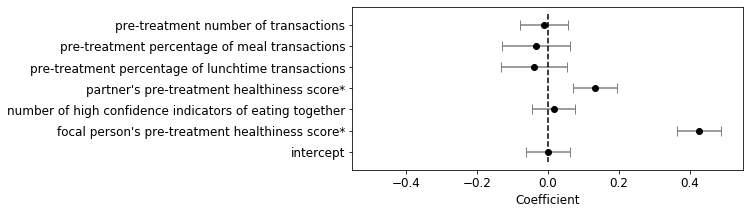

In [16]:
fig, ax = plt.subplots(figsize = (7,3))


import matplotlib 
matplotlib.rcParams.update({'font.size': 13})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


conf_int = res.conf_int().values

colors = [
    'tab:orange',
    'tab:orange',
    'tab:orange',
    'black',
    'black',
    'tab:orange',
    'black'
]

for i in range(len(conf_int)):
    l_error = [res.params.values[i] - conf_int[i][0]]
    u_error = [conf_int[i][1] - res.params.values[i]]
    asymetric_error = [l_error, u_error]

    ax.errorbar(
               [res.params.values[i] ],[i],
               xerr = asymetric_error, capsize=5, color = 'gray')
    ax.plot([res.params.values[i] ],[i], marker = 'o', color = 'black')


ytick_labels = []
for cnt,i in enumerate(res.pvalues):
    if i < 0.05:
        ytick_labels.append(res.params.index[cnt]+'*')
    else:
        ytick_labels.append(res.params.index[cnt])

ytick_labels = ['intercept',
 'focal person\'s pre-treatment healthiness score*',
 'number of high confidence indicators of eating together',
 'partner\'s pre-treatment healthiness score*',
 'pre-treatment percentage of lunchtime transactions',
 'pre-treatment percentage of meal transactions',
 'pre-treatment number of transactions']



plt.yticks(range(len(conf_int)),ytick_labels)

plt.xlabel('Coefficient')

plt.xlim([-0.55,0.55])
plt.vlines(0,6.5,-0.5, linestyle = '--')

plt.savefig("rq1.pdf", bbox_inches='tight')

### b) Effect estimation 6 months, contingency table

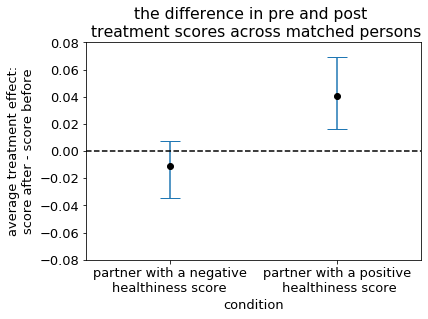

In [17]:
diff = []
Ns = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+7]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+7]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

clean_c_pre = [i for cnt,i in enumerate(c_pre) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_pre = [i for cnt,i in enumerate(t_pre) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_c_post = [i for cnt,i in enumerate(c_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_post = [i for cnt,i in enumerate(t_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]

c_pre = clean_c_pre
t_pre = clean_t_pre
t_post = clean_t_post
c_post = clean_c_post




l_error = [np.mean(np.array(c_post) - np.array(c_pre)) - lower_error(np.array(c_post) - np.array(c_pre))]
u_error = [upper_error(np.array(c_post) - np.array(c_pre)) - np.mean(np.array(c_post) - np.array(c_pre))]
asymetric_error = [l_error, u_error]

plt.errorbar([0],
           [np.mean(np.array(c_post) - np.array(c_pre)) ],
           yerr = asymetric_error, capsize=10, color = 'tab:blue')

plt.plot([0],[np.mean(np.array(c_post) - np.array(c_pre))] , ls = 'none', marker = 'o', color = 'black')


l_error = [np.mean(np.array(t_post) - np.array(t_pre)) - lower_error(np.array(t_post) - np.array(t_pre))]
u_error = [upper_error(np.array(t_post) - np.array(t_pre)) - np.mean(np.array(t_post) - np.array(t_pre))]
asymetric_error = [l_error, u_error]

plt.errorbar([1],
           [np.mean(np.array(t_post) - np.array(t_pre)) ],
           yerr = asymetric_error, capsize=10, color = 'tab:blue')

plt.plot([1],[np.mean(np.array(t_post) - np.array(t_pre))] , ls = 'none', marker = 'o', color = 'black')



plt.xticks([0,1],['partner with a negative\nhealthiness score','partner with a positive\n healthiness score'])
plt.title('the difference in pre and post \n treatment scores across matched persons')
plt.ylabel('average treatment effect:\nscore after - score before')
plt.xlabel('condition')

plt.ylim([-.08,0.08])
plt.xlim([-.5,1.5])
plt.hlines(0,-0.5,1.5, linestyle = '--')

plt.savefig("rq1_6.pdf", bbox_inches='tight')

In [19]:
matrix = np.zeros((2,2))

for i in range(len(t_pre)):
    if not(np.isnan(t_pre[i])) and not(np.isnan(t_post[i])) and not(np.isnan(c_pre[i])) and not(np.isnan(c_post[i])):
        
        if c_post[i]> c_pre[i] and t_post[i] > t_pre[i]:
            matrix[0,0]+=1
        
        if c_post[i]<= c_pre[i] and t_post[i] <= t_pre[i]:
            matrix[1,1]+=1
        
        if c_post[i]<= c_pre[i] and t_post[i] > t_pre[i]:
            matrix[0,1]+=1
            
        if c_post[i]> c_pre[i] and t_post[i] <= t_pre[i]:
            matrix[1,0]+=1
    else:
        matrix[1,1]+=1

In [20]:
print(mcnemar(matrix))

pvalue      0.007088323424841725
statistic   67.0


In [21]:
print(fisher_exact(matrix))

(2.154470366613534, 0.00016229433925866982)


In [22]:
from scipy.stats import chisquare

In [23]:
chisquare([126, 103, 67, 119])

Power_divergenceResult(statistic=20.036144578313255, pvalue=0.00016683974664766723)

### c) Sensitivity plot

In [29]:
x = ['1.45', '1.45355355355355', '1.45710710710711', '1.46066066066066', '1.46421421421421', '1.46776776776777', '1.47132132132132', '1.47487487487487', '1.47842842842843', '1.48198198198198', '1.48553553553554', '1.48908908908909', '1.49264264264264', '1.4961961961962', '1.49974974974975', '1.5033033033033', '1.50685685685686', '1.51041041041041', '1.51396396396396', '1.51751751751752', '1.52107107107107', '1.52462462462462', '1.52817817817818', '1.53173173173173', '1.53528528528529', '1.53883883883884', '1.54239239239239', '1.54594594594595', '1.5494994994995', '1.55305305305305', '1.55660660660661', '1.56016016016016', '1.56371371371371', '1.56726726726727', '1.57082082082082', '1.57437437437437', '1.57792792792793', '1.58148148148148', '1.58503503503504', '1.58858858858859', '1.59214214214214', '1.5956956956957', '1.59924924924925', '1.6028028028028', '1.60635635635636', '1.60990990990991', '1.61346346346346', '1.61701701701702', '1.62057057057057', '1.62412412412412', '1.62767767767768', '1.63123123123123', '1.63478478478478', '1.63833833833834', '1.64189189189189', '1.64544544544545', '1.648998998999', '1.65255255255255', '1.65610610610611', '1.65965965965966', '1.66321321321321', '1.66676676676677', '1.67032032032032', '1.67387387387387', '1.67742742742743', '1.68098098098098', '1.68453453453453', '1.68808808808809', '1.69164164164164', '1.6951951951952', '1.69874874874875', '1.7023023023023', '1.70585585585586', '1.70940940940941', '1.71296296296296', '1.71651651651652', '1.72007007007007', '1.72362362362362', '1.72717717717718', '1.73073073073073', '1.73428428428428', '1.73783783783784', '1.74139139139139', '1.74494494494494', '1.7484984984985', '1.75205205205205', '1.75560560560561', '1.75915915915916', '1.76271271271271', '1.76626626626627', '1.76981981981982', '1.77337337337337', '1.77692692692693', '1.78048048048048', '1.78403403403403', '1.78758758758759', '1.79114114114114', '1.79469469469469', '1.79824824824825', '1.8018018018018', '1.80535535535536', '1.80890890890891', '1.81246246246246', '1.81601601601602', '1.81956956956957', '1.82312312312312', '1.82667667667668', '1.83023023023023', '1.83378378378378', '1.83733733733734', '1.84089089089089', '1.84444444444444', '1.847997997998', '1.85155155155155', '1.85510510510511', '1.85865865865866', '1.86221221221221', '1.86576576576577', '1.86931931931932', '1.87287287287287', '1.87642642642643', '1.87997997997998', '1.88353353353353', '1.88708708708709', '1.89064064064064', '1.89419419419419', '1.89774774774775', '1.9013013013013', '1.90485485485485', '1.90840840840841', '1.91196196196196', '1.91551551551552', '1.91906906906907', '1.92262262262262', '1.92617617617618', '1.92972972972973', '1.93328328328328', '1.93683683683684', '1.94039039039039', '1.94394394394394', '1.9474974974975', '1.95105105105105', '1.9546046046046', '1.95815815815816', '1.96171171171171', '1.96526526526527', '1.96881881881882', '1.97237237237237', '1.97592592592593', '1.97947947947948', '1.98303303303303', '1.98658658658659', '1.99014014014014', '1.99369369369369', '1.99724724724725', '2.0008008008008', '2.00435435435435', '2.00790790790791', '2.01146146146146', '2.01501501501502', '2.01856856856857', '2.02212212212212', '2.02567567567568', '2.02922922922923', '2.03278278278278', '2.03633633633634', '2.03988988988989', '2.04344344344344', '2.046996996997', '2.05055055055055', '2.0541041041041', '2.05765765765766', '2.06121121121121', '2.06476476476476', '2.06831831831832', '2.07187187187187', '2.07542542542543', '2.07897897897898', '2.08253253253253', '2.08608608608609', '2.08963963963964', '2.09319319319319', '2.09674674674675', '2.1003003003003', '2.10385385385385', '2.10740740740741', '2.11096096096096', '2.11451451451451', '2.11806806806807', '2.12162162162162', '2.12517517517518', '2.12872872872873', '2.13228228228228', '2.13583583583584', '2.13938938938939', '2.14294294294294', '2.1464964964965', '2.15005005005005', '2.1536036036036', '2.15715715715716', '2.16071071071071', '2.16426426426426', '2.16781781781782', '2.17137137137137', '2.17492492492492', '2.17847847847848', '2.18203203203203', '2.18558558558559', '2.18913913913914', '2.19269269269269', '2.19624624624625', '2.1997997997998', '2.20335335335335', '2.20690690690691', '2.21046046046046', '2.21401401401401', '2.21756756756757', '2.22112112112112', '2.22467467467467', '2.22822822822823', '2.23178178178178', '2.23533533533534', '2.23888888888889', '2.24244244244244', '2.245995995996', '2.24954954954955', '2.2531031031031', '2.25665665665666', '2.26021021021021', '2.26376376376376', '2.26731731731732', '2.27087087087087', '2.27442442442442', '2.27797797797798', '2.28153153153153', '2.28508508508509', '2.28863863863864', '2.29219219219219', '2.29574574574575', '2.2992992992993', '2.30285285285285', '2.30640640640641', '2.30995995995996', '2.31351351351351', '2.31706706706707', '2.32062062062062', '2.32417417417417', '2.32772772772773', '2.33128128128128', '2.33483483483483', '2.33838838838839', '2.34194194194194', '2.3454954954955', '2.34904904904905', '2.3526026026026', '2.35615615615616', '2.35970970970971', '2.36326326326326', '2.36681681681682', '2.37037037037037', '2.37392392392392', '2.37747747747748', '2.38103103103103', '2.38458458458458', '2.38813813813814', '2.39169169169169', '2.39524524524525', '2.3987987987988', '2.40235235235235', '2.40590590590591', '2.40945945945946', '2.41301301301301', '2.41656656656657', '2.42012012012012', '2.42367367367367', '2.42722722722723', '2.43078078078078', '2.43433433433433', '2.43788788788789', '2.44144144144144', '2.44499499499499', '2.44854854854855', '2.4521021021021', '2.45565565565566', '2.45920920920921', '2.46276276276276', '2.46631631631632', '2.46986986986987', '2.47342342342342', '2.47697697697698', '2.48053053053053', '2.48408408408408', '2.48763763763764', '2.49119119119119', '2.49474474474474', '2.4982982982983', '2.50185185185185', '2.50540540540541', '2.50895895895896', '2.51251251251251', '2.51606606606607', '2.51961961961962', '2.52317317317317', '2.52672672672673', '2.53028028028028', '2.53383383383383', '2.53738738738739', '2.54094094094094', '2.54449449449449', '2.54804804804805', '2.5516016016016', '2.55515515515516', '2.55870870870871', '2.56226226226226', '2.56581581581582', '2.56936936936937', '2.57292292292292', '2.57647647647648', '2.58003003003003', '2.58358358358358', '2.58713713713714', '2.59069069069069', '2.59424424424424', '2.5977977977978', '2.60135135135135', '2.60490490490491', '2.60845845845846', '2.61201201201201', '2.61556556556557', '2.61911911911912', '2.62267267267267', '2.62622622622623', '2.62977977977978', '2.63333333333333', '2.63688688688689', '2.64044044044044', '2.64399399399399', '2.64754754754755', '2.6511011011011', '2.65465465465465', '2.65820820820821', '2.66176176176176', '2.66531531531532', '2.66886886886887', '2.67242242242242', '2.67597597597598', '2.67952952952953', '2.68308308308308', '2.68663663663664', '2.69019019019019', '2.69374374374374', '2.6972972972973', '2.70085085085085', '2.7044044044044', '2.70795795795796', '2.71151151151151', '2.71506506506506', '2.71861861861862', '2.72217217217217', '2.72572572572573', '2.72927927927928', '2.73283283283283', '2.73638638638639', '2.73993993993994', '2.74349349349349', '2.74704704704705', '2.7506006006006', '2.75415415415415', '2.75770770770771', '2.76126126126126', '2.76481481481481', '2.76836836836837', '2.77192192192192', '2.77547547547548', '2.77902902902903', '2.78258258258258', '2.78613613613614', '2.78968968968969', '2.79324324324324', '2.7967967967968', '2.80035035035035', '2.8039039039039', '2.80745745745746', '2.81101101101101', '2.81456456456456', '2.81811811811812', '2.82167167167167', '2.82522522522522', '2.82877877877878', '2.83233233233233', '2.83588588588589', '2.83943943943944', '2.84299299299299', '2.84654654654655', '2.8501001001001', '2.85365365365365', '2.85720720720721', '2.86076076076076', '2.86431431431431', '2.86786786786787', '2.87142142142142', '2.87497497497497', '2.87852852852853', '2.88208208208208', '2.88563563563564', '2.88918918918919', '2.89274274274274', '2.8962962962963', '2.89984984984985', '2.9034034034034', '2.90695695695696', '2.91051051051051', '2.91406406406406', '2.91761761761762', '2.92117117117117', '2.92472472472472', '2.92827827827828', '2.93183183183183', '2.93538538538539', '2.93893893893894', '2.94249249249249', '2.94604604604605', '2.9495995995996', '2.95315315315315', '2.95670670670671', '2.96026026026026', '2.96381381381381', '2.96736736736737', '2.97092092092092', '2.97447447447447', '2.97802802802803', '2.98158158158158', '2.98513513513513', '2.98868868868869', '2.99224224224224', '2.9957957957958', '2.99934934934935', '3.0029029029029', '3.00645645645646', '3.01001001001001', '3.01356356356356', '3.01711711711712', '3.02067067067067', '3.02422422422422', '3.02777777777778', '3.03133133133133', '3.03488488488488', '3.03843843843844', '3.04199199199199', '3.04554554554555', '3.0490990990991', '3.05265265265265', '3.05620620620621', '3.05975975975976', '3.06331331331331', '3.06686686686687', '3.07042042042042', '3.07397397397397', '3.07752752752753', '3.08108108108108', '3.08463463463463', '3.08818818818819', '3.09174174174174', '3.0952952952953', '3.09884884884885', '3.1024024024024', '3.10595595595596', '3.10950950950951', '3.11306306306306', '3.11661661661662', '3.12017017017017', '3.12372372372372', '3.12727727727728', '3.13083083083083', '3.13438438438438', '3.13793793793794', '3.14149149149149', '3.14504504504504', '3.1485985985986', '3.15215215215215', '3.15570570570571', '3.15925925925926', '3.16281281281281', '3.16636636636637', '3.16991991991992', '3.17347347347347', '3.17702702702703', '3.18058058058058', '3.18413413413413', '3.18768768768769', '3.19124124124124', '3.19479479479479', '3.19834834834835', '3.2019019019019', '3.20545545545546', '3.20900900900901', '3.21256256256256', '3.21611611611612', '3.21966966966967', '3.22322322322322', '3.22677677677678', '3.23033033033033', '3.23388388388388', '3.23743743743744', '3.24099099099099', '3.24454454454454', '3.2480980980981', '3.25165165165165', '3.2552052052052', '3.25875875875876', '3.26231231231231', '3.26586586586587', '3.26941941941942', '3.27297297297297', '3.27652652652653', '3.28008008008008', '3.28363363363363', '3.28718718718719', '3.29074074074074', '3.29429429429429', '3.29784784784785', '3.3014014014014', '3.30495495495495', '3.30850850850851', '3.31206206206206', '3.31561561561562', '3.31916916916917', '3.32272272272272', '3.32627627627628', '3.32982982982983', '3.33338338338338', '3.33693693693694', '3.34049049049049', '3.34404404404404', '3.3475975975976', '3.35115115115115', '3.3547047047047', '3.35825825825826', '3.36181181181181', '3.36536536536537', '3.36891891891892', '3.37247247247247', '3.37602602602603', '3.37957957957958', '3.38313313313313', '3.38668668668669', '3.39024024024024', '3.39379379379379', '3.39734734734735', '3.4009009009009', '3.40445445445445', '3.40800800800801', '3.41156156156156', '3.41511511511511', '3.41866866866867', '3.42222222222222', '3.42577577577578', '3.42932932932933', '3.43288288288288', '3.43643643643644', '3.43998998998999', '3.44354354354354', '3.4470970970971', '3.45065065065065', '3.4542042042042', '3.45775775775776', '3.46131131131131', '3.46486486486486', '3.46841841841842', '3.47197197197197', '3.47552552552553', '3.47907907907908', '3.48263263263263', '3.48618618618619', '3.48973973973974', '3.49329329329329', '3.49684684684685', '3.5004004004004', '3.50395395395395', '3.50750750750751', '3.51106106106106', '3.51461461461461', '3.51816816816817', '3.52172172172172', '3.52527527527528', '3.52882882882883', '3.53238238238238', '3.53593593593594', '3.53948948948949', '3.54304304304304', '3.5465965965966', '3.55015015015015', '3.5537037037037', '3.55725725725726', '3.56081081081081', '3.56436436436436', '3.56791791791792', '3.57147147147147', '3.57502502502502', '3.57857857857858', '3.58213213213213', '3.58568568568569', '3.58923923923924', '3.59279279279279', '3.59634634634635', '3.5998998998999', '3.60345345345345', '3.60700700700701', '3.61056056056056', '3.61411411411411', '3.61766766766767', '3.62122122122122', '3.62477477477477', '3.62832832832833', '3.63188188188188', '3.63543543543544', '3.63898898898899', '3.64254254254254', '3.6460960960961', '3.64964964964965', '3.6532032032032', '3.65675675675676', '3.66031031031031', '3.66386386386386', '3.66741741741742', '3.67097097097097', '3.67452452452452', '3.67807807807808', '3.68163163163163', '3.68518518518519', '3.68873873873874', '3.69229229229229', '3.69584584584585', '3.6993993993994', '3.70295295295295', '3.70650650650651', '3.71006006006006', '3.71361361361361', '3.71716716716717', '3.72072072072072', '3.72427427427427', '3.72782782782783', '3.73138138138138', '3.73493493493493', '3.73848848848849', '3.74204204204204', '3.7455955955956', '3.74914914914915', '3.7527027027027', '3.75625625625626', '3.75980980980981', '3.76336336336336', '3.76691691691692', '3.77047047047047', '3.77402402402402', '3.77757757757758', '3.78113113113113', '3.78468468468468', '3.78823823823824', '3.79179179179179', '3.79534534534535', '3.7988988988989', '3.80245245245245', '3.80600600600601', '3.80955955955956', '3.81311311311311', '3.81666666666667', '3.82022022022022', '3.82377377377377', '3.82732732732733', '3.83088088088088', '3.83443443443443', '3.83798798798799', '3.84154154154154', '3.8450950950951', '3.84864864864865', '3.8522022022022', '3.85575575575576', '3.85930930930931', '3.86286286286286', '3.86641641641642', '3.86996996996997', '3.87352352352352', '3.87707707707708', '3.88063063063063', '3.88418418418418', '3.88773773773774', '3.89129129129129', '3.89484484484484', '3.8983983983984', '3.90195195195195', '3.90550550550551', '3.90905905905906', '3.91261261261261', '3.91616616616617', '3.91971971971972', '3.92327327327327', '3.92682682682683', '3.93038038038038', '3.93393393393393', '3.93748748748749', '3.94104104104104', '3.94459459459459', '3.94814814814815', '3.9517017017017', '3.95525525525526', '3.95880880880881', '3.96236236236236', '3.96591591591592', '3.96946946946947', '3.97302302302302', '3.97657657657658', '3.98013013013013', '3.98368368368368', '3.98723723723724', '3.99079079079079', '3.99434434434434', '3.9978978978979', '4.00145145145145', '4.00500500500501', '4.00855855855856', '4.01211211211211', '4.01566566566567', '4.01921921921922', '4.02277277277277', '4.02632632632633', '4.02987987987988', '4.03343343343343', '4.03698698698699', '4.04054054054054', '4.04409409409409', '4.04764764764765', '4.0512012012012', '4.05475475475475', '4.05830830830831', '4.06186186186186', '4.06541541541542', '4.06896896896897', '4.07252252252252', '4.07607607607608', '4.07962962962963', '4.08318318318318', '4.08673673673674', '4.09029029029029', '4.09384384384384', '4.0973973973974', '4.10095095095095', '4.1045045045045', '4.10805805805806', '4.11161161161161', '4.11516516516517', '4.11871871871872', '4.12227227227227', '4.12582582582583', '4.12937937937938', '4.13293293293293', '4.13648648648649', '4.14004004004004', '4.14359359359359', '4.14714714714715', '4.1507007007007', '4.15425425425425', '4.15780780780781', '4.16136136136136', '4.16491491491491', '4.16846846846847', '4.17202202202202', '4.17557557557558', '4.17912912912913', '4.18268268268268', '4.18623623623624', '4.18978978978979', '4.19334334334334', '4.1968968968969', '4.20045045045045', '4.204004004004', '4.20755755755756', '4.21111111111111', '4.21466466466466', '4.21821821821822', '4.22177177177177', '4.22532532532533', '4.22887887887888', '4.23243243243243', '4.23598598598599', '4.23953953953954', '4.24309309309309', '4.24664664664665', '4.2502002002002', '4.25375375375375', '4.25730730730731', '4.26086086086086', '4.26441441441441', '4.26796796796797', '4.27152152152152', '4.27507507507508', '4.27862862862863', '4.28218218218218', '4.28573573573574', '4.28928928928929', '4.29284284284284', '4.2963963963964', '4.29994994994995', '4.3035035035035', '4.30705705705706', '4.31061061061061', '4.31416416416416', '4.31771771771772', '4.32127127127127', '4.32482482482482', '4.32837837837838', '4.33193193193193', '4.33548548548548', '4.33903903903904', '4.34259259259259', '4.34614614614615', '4.3496996996997', '4.35325325325325', '4.35680680680681', '4.36036036036036', '4.36391391391391', '4.36746746746747', '4.37102102102102', '4.37457457457457', '4.37812812812813', '4.38168168168168', '4.38523523523523', '4.38878878878879', '4.39234234234234', '4.3958958958959', '4.39944944944945', '4.403003003003', '4.40655655655656', '4.41011011011011', '4.41366366366366', '4.41721721721722', '4.42077077077077', '4.42432432432432', '4.42787787787788', '4.43143143143143', '4.43498498498499', '4.43853853853854', '4.44209209209209', '4.44564564564565', '4.4491991991992', '4.45275275275275', '4.45630630630631', '4.45985985985986', '4.46341341341341', '4.46696696696697', '4.47052052052052', '4.47407407407407', '4.47762762762763', '4.48118118118118', '4.48473473473473', '4.48828828828829', '4.49184184184184', '4.49539539539539', '4.49894894894895', '4.5025025025025', '4.50605605605606', '4.50960960960961', '4.51316316316316', '4.51671671671672', '4.52027027027027', '4.52382382382382', '4.52737737737738', '4.53093093093093', '4.53448448448448', '4.53803803803804', '4.54159159159159', '4.54514514514514', '4.5486986986987', '4.55225225225225', '4.55580580580581', '4.55935935935936', '4.56291291291291', '4.56646646646647', '4.57002002002002', '4.57357357357357', '4.57712712712713', '4.58068068068068', '4.58423423423423', '4.58778778778779', '4.59134134134134', '4.5948948948949', '4.59844844844845', '4.602002002002', '4.60555555555556', '4.60910910910911', '4.61266266266266', '4.61621621621622', '4.61976976976977', '4.62332332332332', '4.62687687687688', '4.63043043043043', '4.63398398398398', '4.63753753753754', '4.64109109109109', '4.64464464464464', '4.6481981981982', '4.65175175175175', '4.6553053053053', '4.65885885885886', '4.66241241241241', '4.66596596596597', '4.66951951951952', '4.67307307307307', '4.67662662662663', '4.68018018018018', '4.68373373373373', '4.68728728728729', '4.69084084084084', '4.69439439439439', '4.69794794794795', '4.7015015015015', '4.70505505505505', '4.70860860860861', '4.71216216216216', '4.71571571571572', '4.71926926926927', '4.72282282282282', '4.72637637637638', '4.72992992992993', '4.73348348348348', '4.73703703703704', '4.74059059059059', '4.74414414414414', '4.7476976976977', '4.75125125125125', '4.7548048048048', '4.75835835835836', '4.76191191191191', '4.76546546546547', '4.76901901901902', '4.77257257257257', '4.77612612612613', '4.77967967967968', '4.78323323323323', '4.78678678678679', '4.79034034034034', '4.79389389389389', '4.79744744744745', '4.801001001001', '4.80455455455455', '4.80810810810811', '4.81166166166166', '4.81521521521521', '4.81876876876877', '4.82232232232232', '4.82587587587588', '4.82942942942943', '4.83298298298298', '4.83653653653654', '4.84009009009009', '4.84364364364364', '4.8471971971972', '4.85075075075075', '4.8543043043043', '4.85785785785786', '4.86141141141141', '4.86496496496496', '4.86851851851852', '4.87207207207207', '4.87562562562563', '4.87917917917918', '4.88273273273273', '4.88628628628629', '4.88983983983984', '4.89339339339339', '4.89694694694695', '4.9005005005005', '4.90405405405405', '4.90760760760761', '4.91116116116116', '4.91471471471471', '4.91826826826827', '4.92182182182182', '4.92537537537538', '4.92892892892893', '4.93248248248248', '4.93603603603604', '4.93958958958959', '4.94314314314314', '4.9466966966967', '4.95025025025025', '4.9538038038038', '4.95735735735736', '4.96091091091091', '4.96446446446446', '4.96801801801802', '4.97157157157157', '4.97512512512512', '4.97867867867868', '4.98223223223223', '4.98578578578579', '4.98933933933934', '4.99289289289289', '4.99644644644645', '5']

In [30]:
y = ['2.4875', '2.47098880926325', '2.45488633986472', '2.43917760099184', '2.42384832607512', '2.40888492957273', '2.39427446681284', '2.38000459664445', '2.36606354667013', '2.35244008085475', '2.33912346932301', '2.32610346017505', '2.31337025316456', '2.30091447509743', '2.28872715682108', '2.27679971168574', '2.26512391536907', '2.25369188696445', '2.24249607124149', '2.23152922199499', '2.22078438640511', '2.21025489033788', '2.19993432452071', '2.18981653153278', '2.17989559355475', '2.17016582082666', '2.16062174076662', '2.15125808770669', '2.14206979320532', '2.13305197689915', '2.12419993785925', '2.11550914641968', '2.10697523644869', '2.09859399803462', '2.09036137056091', '2.08227343614625', '2.07432641342756', '2.06651665166517', '2.05884062515074', '2.05129492790014', '2.04387626861425', '2.03658146589226', '2.02940744368266', '2.02235122695839', '2.01540993760323', '2.00858079049764', '2.00186108979279', '1.9952482253622', '1.98873966942149', '1.98233297330659', '1.97602576440226', '1.96981574321245', '1.96370068056513', '1.95767841494432', '1.95174684994273', '1.94590395182854', '1.9401477472206', '1.93447632086626', '1.92888781351674', '1.92338041989492', '1.9179523867511', '1.91260201100208', '1.90732763794966', '1.90212765957447', '1.89700051290144', '1.8919446784336', '1.88695867865064', '1.88204107656935', '1.87719047436291', '1.87240551203614', '1.86768486615425', '1.86302724862252', '1.85843140551446', '1.85389611594633', '1.84942019099591', '1.84500247266333', '1.84064183287232', '1.83633717250981', '1.83208742050232', '1.8278915329275', '1.82374849215923', '1.81965730604474', '1.81561700711257', '1.81162665180981', '1.80768531976744', '1.80379211309268', '1.79994615568698', '1.79614659258882', '1.79239258934', '1.78868333137475', '1.78501802343046', '1.78139588897921', '1.77781616967938', '1.77427812484628', '1.77078103094128', '1.7673241810785', '1.76390688454844', '1.76052846635794', '1.75718826678563', '1.75388564095252', '1.75061995840686', '1.74739060272299', '1.7441969711134', '1.74103847405364', '1.73791453491956', '1.7348245896363', '1.73176808633883', '1.72874448504329', '1.72575325732899', '1.72279388603057', '1.71986586493987', '1.7169686985173', '1.71410190161224', '1.71126499919221', '1.70845752608048', '1.70567902670175', '1.70292905483572', '1.70020717337822', '1.69751295410953', '1.69484597746984', '1.69220583234144', '1.68959211583741', '1.68700443309671', '1.6844423970853', '1.68190562840316', '1.67939375509696', '1.67690641247834', '1.67444324294729', '1.67200389582085', '1.66958802716662', '1.66719529964113', '1.6648253823328', '1.66247795060936', '1.66015268596965', '1.6578492758995', '1.65556741373177', '1.6533067985102', '1.65106713485713', '1.64884813284478', '1.6466495078702', '1.64447098053353', '1.64231227651967', '1.64017312648312', '1.63805326593596', '1.63595243513883', '1.6338703789948', '1.63180684694619', '1.62976159287398', '1.627734375', '1.62572495579161', '1.62373310186895', '1.62175858391458', '1.61980117658546', '1.61786065842721', '1.61593681179061', '1.61402942275022', '1.61213828102505', '1.61026317990132', '1.60840391615712', '1.60656028998898', '1.60473210494031', '1.60291916783159', '1.60112128869236', '1.5993382806948', '1.5975699600891', '1.59581614614025', '1.59407666106649', '1.59235132997926', '1.59063998082454', '1.58894244432571', '1.58725855392767', '1.58558814574241', '1.58393105849582', '1.58228713347578', '1.58065621448151', '1.57903814777407', '1.57743278202804', '1.57583996828438', '1.57425955990435', '1.57269141252445', '1.57113538401254', '1.56959133442484', '1.56805912596401', '1.56653862293812', '1.56502969172062', '1.56353220071118', '1.56204602029744', '1.5605710228176', '1.55910708252386', '1.55765407554672', '1.55621187985999', '1.55478037524667', '1.55335944326551', '1.55194896721838', '1.5505488321183', '1.54915892465817', '1.54777913318025', '1.54640934764624', '1.54504945960799', '1.54369936217893', '1.54235895000606', '1.5410281192425', '1.53970676752072', '1.53839479392625', '1.53709209897203', '1.53579858457324', '1.53451415402267', '1.53323871196665', '1.53197216438141', '1.53071441855002', '1.52946538303974', '1.52822496767985', '1.52699308353999', '1.52576964290886', '1.52455455927344', '1.52334774729858', '1.52214912280702', '1.52095860275982', '1.51977610523718', '1.51860154941968', '1.5174348555698', '1.51627594501395', '1.51512474012474', '1.51398116430365', '1.51284514196405', '1.51171659851456', '1.51059546034269', '1.50948165479886', '1.5083751101807', '1.50727575571765', '1.50618352155589', '1.50509833874356', '1.50402013921618', '1.50294885578252', '1.50188442211055', '1.50082677271381', '1.49977584293793', '1.49873156894752', '1.49769388771318', '1.49666273699886', '1.49563805534938', '1.49461978207827', '1.49360785725576', '1.492602221697', '1.49160281695057', '1.49060958528713', '1.4896224696883', '1.48864141383574', '1.48766636210047', '1.48669725953234', '1.48573405184969', '1.48477668542925', '1.48382510729614', '1.48287926511415', '1.48193910717611', '1.48100458239449', '1.48007564029213', '1.47915223099315', '1.47823430521403', '1.47732181425486', '1.47641470999069', '1.47551294486309', '1.47461647187185', '1.47372524456678', '1.47283921703974', '1.47195834391669', '1.47108258034999', '1.4702118820108', '1.46934620508155', '1.46848550624863', '1.46762974269516', '1.46677887209387', '1.46593285260013', '1.46509164284513', '1.46425520192907', '1.46342348941456', '1.46259646532012', '1.46177409011377', '1.4609563247067', '1.46014313044711', '1.45933446911409', '1.45853030291168', '1.45773059446292', '1.45693530680411', '1.45614440337909', '1.45535784803364', '1.45457560500996', '1.4537976389413', '1.45302391484656', '1.4522543981251', '1.45148905455156', '1.4507278502708', '1.44997075179288', '1.44921772598817', '1.44846874008251', '1.44772376165249', '1.44698275862069', '1.44624569925116', '1.44551255214485', '1.44478328623515', '1.44405787078351', '1.44333627537511', '1.44261846991463', '1.44190442462206', '1.44119411002855', '1.44048749697241', '1.43978455659507', '1.43908526033719', '1.43838957993475', '1.43769748741528', '1.43700895509412', '1.43632395557065', '1.43564246172476', '1.43496444671321', '1.43428988396609', '1.43361874718342', '1.43295101033164', '1.43228664764033', '1.43162563359884', '1.43096794295304', '1.43031355070212', '1.42966243209537', '1.42901456262914', '1.42836991804371', '1.42772847432024', '1.42709020767787', '1.42645509457071', '1.42582311168496', '1.42519423593607', '1.42456844446593', '1.4239457146401', '1.42332602404504', '1.42270935048549', '1.42209567198178', '1.42148496676721', '1.4208772132855', '1.42027239018825', '1.41967047633242', '1.4190714507779', '1.41847529278505', '1.41788198181231', '1.41729149751387', '1.41670381973732', '1.41611892852134', '1.41553680409349', '1.41495742686793', '1.41438077744327', '1.41380683660036', '1.41323558530017', '1.41266700468173', '1.41210107605996', '1.41153778092373', '1.41097710093375', '1.41041901792063', '1.40986351388292', '1.40931057098515', '1.40876017155592', '1.40821229808606', '1.40766693322671', '1.40712405978754', '1.40658366073492', '1.40604571919015', '1.40551021842768', '1.40497714187341', '1.40444647310296', '1.40391819583997', '1.40339229395448', '1.40286875146123', '1.40234755251809', '1.40182868142445', '1.4013121226196', '1.40079786068125', '1.40028588032394', '1.39977616639753', '1.39926870388573', '1.39876347790462', '1.39826047370116', '1.39775967665181', '1.39726107226107', '1.39676464616009', '1.39627038410531', '1.39577827197706', '1.39528829577826', '1.39480044163307', '1.39431469578555', '1.39383104459844', '1.39334947455182', '1.39286997224188', '1.39239252437965', '1.39191711778981', '1.39144373940945', '1.3909723762869', '1.3905030155805', '1.39003564455749', '1.38957025059282', '1.38910682116804', '1.38864534387014', '1.3881858063905', '1.38772819652373', '1.38727250216665', '1.38681871131716', '1.38636681207325', '1.38591679263191', '1.38546864128814', '1.38502234643391', '1.38457789655715', '1.38413528024079', '1.38369448616177', '1.38325550309006', '1.38281831988774', '1.382382925508', '1.38194930899429', '1.38151745947931', '1.38108736618419', '1.38065901841753', '1.38023240557454', '1.37980751713616', '1.37938434266819', '1.37896287182046', '1.37854309432596', '1.378125', '1.37770857873943', '1.37729382052176', '1.37688071540444', '1.37646925352397', '1.37605942509519', '1.37565122041049', '1.37524462983899', '1.37483964382587', '1.37443625289154', '1.37403444763096', '1.37363421871287', '1.37323555687909', '1.3728384529438', '1.37244289779282', '1.37204888238293', '1.3716563977412', '1.37126543496426', '1.37087598521765', '1.37048803973517', '1.37010158981821', '1.3697166268351', '1.36933314222044', '1.36895112747453', '1.36857057416268', '1.36819147391461', '1.36781381842385', '1.36743759944711', '1.36706280880371', '1.36668943837495', '1.36631748010356', '1.36594692599308', '1.36557776810733', '1.36520999856982', '1.36484360956319', '1.36447859332865', '1.36411494216548', '1.36375264843039', '1.36339170453711', '1.36303210295573', '1.3626738362123', '1.36231689688823', '1.36196127761978', '1.3616069710976', '1.36125397006622', '1.3609022673235', '1.36055185572021', '1.3602027281595', '1.35985487759644', '1.35950829703754', '1.3591629795403', '1.3588189182127', '1.35847610621279', '1.35813453674823', '1.35779420307579', '1.35745509850099', '1.35711721637759', '1.35678055010719', '1.35644509313879', '1.35611083896837', '1.35577778113847', '1.35544591323776', '1.35511522890065', '1.35478572180689', '1.35445738568111', '1.35413021429249', '1.35380420145435', '1.35347934102371', '1.35315562690098', '1.35283305302951', '1.35251161339527', '1.35219130202643', '1.35187211299301', '1.35155404040653', '1.35123707841961', '1.35092122122564', '1.35060646305844', '1.35029279819184', '1.34998022093943', '1.34966872565414', '1.34935830672792', '1.34904895859144', '1.34874067571369', '1.34843345260171', '1.34812728380024', '1.34782216389139', '1.34751808749434', '1.34721504926499', '1.34691304389569', '1.34661206611491', '1.34631211068691', '1.34601317241149', '1.34571524612362', '1.34541832669323', '1.34512240902481', '1.34482748805723', '1.34453355876336', '1.34424061614982', '1.34394865525672', '1.34365767115735', '1.34336765895791', '1.34307861379722', '1.34279053084648', '1.34250340530901', '1.3422172324199', '1.34193200744587', '1.3416477256849', '1.34136438246604', '1.34108197314913', '1.34080049312453', '1.3405199378129', '1.34024030266495', '1.33996158316116', '1.33968377481157', '1.33940687315553', '1.33913087376146', '1.3388557722266', '1.33858156417681', '1.3383082452663', '1.33803581117743', '1.33776425762045', '1.33749358033332', '1.33722377508145', '1.33695483765748', '1.3366867638811', '1.33641954959878', '1.33615319068358', '1.33588768303497', '1.33562302257856', '1.33535920526592', '1.33509622707439', '1.33483408400685', '1.33457277209153', '1.33431228738179', '1.33405262595597', '1.33379378391712', '1.33353575739288', '1.33327854253523', '1.33302213552034', '1.33276653254835', '1.33251172984319', '1.33225772365241', '1.33200451024696', '1.33175208592107', '1.33150044699201', '1.33124958979991', '1.33099951070764', '1.33075020610058', '1.33050167238646', '1.33025390599521', '1.33000690337875', '1.32976066101085', '1.32951517538696', '1.32927044302402', '1.32902646046034', '1.32878322425538', '1.32854073098962', '1.32829897726443', '1.32805795970184', '1.32781767494444', '1.3275781196552', '1.32733929051732', '1.32710118423408', '1.3268637975287', '1.32662712714414', '1.32639116984303', '1.32615592240744', '1.32592138163879', '1.3256875443577', '1.32545440740381', '1.32522196763569', '1.32499022193063', '1.32475916718459', '1.32452880031197', '1.32429911824553', '1.32407011793626', '1.32384179635319', '1.32361415048331', '1.32338717733141', '1.32316087391996', '1.32293523728898', '1.32271026449589', '1.32248595261542', '1.32226229873945', '1.3220392999769', '1.3218169534536', '1.32159525631216', '1.32137420571189', '1.32115379882861', '1.32093403285456', '1.32071490499832', '1.32049641248464', '1.32027855255432', '1.32006132246414', '1.31984471948671', '1.31962874091036', '1.31941338403905', '1.31919864619221', '1.31898452470468', '1.31877101692657', '1.31855812022316', '1.31834583197479', '1.31813414957674', '1.31792307043916', '1.31771259198692', '1.31750271165954', '1.31729342691106', '1.31708473520995', '1.31687663403903', '1.3166691208953', '1.31646219328993', '1.3162558487481', '1.3160500848089', '1.31584489902528', '1.31564028896389', '1.31543625220504', '1.31523278634257', '1.31502988898377', '1.31482755774929', '1.31462579027302', '1.31442458420203', '1.31422393719646', '1.31402384692944', '1.313824311087', '1.31362532736796', '1.31342689348387', '1.3132290071589', '1.31303166612978', '1.31283486814567', '1.31263861096812', '1.31244289237096', '1.31224771014023', '1.31205306207407', '1.31185894598267', '1.31166535968817', '1.31147230102458', '1.3112797678377', '1.31108775798505', '1.31089626933576', '1.31070529977054', '1.31051484718155', '1.31032490947237', '1.31013548455788', '1.30994657036421', '1.30975816482866', '1.30957026589963', '1.30938287153652', '1.3091959797097', '1.30900958840037', '1.30882369560058', '1.30863829931307', '1.30845339755125', '1.30826898833911', '1.30808506971115', '1.30790163971232', '1.30771869639794', '1.30753623783364', '1.30735426209529', '1.30717276726891', '1.30699175145065', '1.30681121274668', '1.30663114927315', '1.30645155915611', '1.30627244053144', '1.3060937915448', '1.30591561035158', '1.30573789511679', '1.30556064401505', '1.30538385523048', '1.30520752695667', '1.30503165739662', '1.30485624476264', '1.30468128727634', '1.30450678316854', '1.30433273067922', '1.30415912805746', '1.30398597356136', '1.30381326545803', '1.30364100202348', '1.30346918154261', '1.30329780230909', '1.30312686262539', '1.30295636080265', '1.30278629516065', '1.30261666402775', '1.30244746574087', '1.30227869864538', '1.30211036109508', '1.30194245145214', '1.30177496808705', '1.30160790937855', '1.30144127371361', '1.30127505948734', '1.30110926510297', '1.3009438889718', '1.30077892951309', '1.3006143851541', '1.30045025432998', '1.30028653548373', '1.30012322706617', '1.29996032753586', '1.29979783535909', '1.29963574900979', '1.29947406696951', '1.29931278772737', '1.29915190978002', '1.29899143163156', '1.29883135179352', '1.29867166878483', '1.29851238113172', '1.29835348736774', '1.29819498603367', '1.29803687567748', '1.29787915485431', '1.29772182212641', '1.2975648760631', '1.29740831524069', '1.29725213824251', '1.29709634365882', '1.29694093008677', '1.29678589613035', '1.29663124040038', '1.29647696151444', '1.29632305809685', '1.2961695287786', '1.29601637219736', '1.29586358699736', '1.29571117182943', '1.29555912535092', '1.29540744622567', '1.29525613312397', '1.2951051847225', '1.29495459970434', '1.29480437675888', '1.29465451458183', '1.29450501187512', '1.29435586734694', '1.29420707971163', '1.29405864768971', '1.29391057000777', '1.29376284539849', '1.2936154726006', '1.29346845035882', '1.29332177742381', '1.29317545255221', '1.2930294745065', '1.29288384205507', '1.2927385539721', '1.29259360903756', '1.29244900603721', '1.29230474376249', '1.29216082101055', '1.2920172365842', '1.29187398929187', '1.29173107794756', '1.29158850137085', '1.29144625838683', '1.29130434782609', '1.29116276852467', '1.29102151932404', '1.29088059907109', '1.29074000661803', '1.29059974082243', '1.29045980054717', '1.29032018466039', '1.29018089203547', '1.290041921551', '1.28990327209076', '1.28976494254368', '1.2896269318038', '1.28948923877026', '1.28935186234726', '1.28921480144404', '1.28907805497485', '1.28894162185888', '1.28880550102032', '1.28866969138824', '1.28853419189661', '1.28839900148428', '1.28826411909491', '1.288129543677', '1.28799527418379', '1.2878613095733', '1.28772764880829', '1.28759429085618', '1.2874612346891', '1.2873284792838', '1.28719602362167', '1.28706386668869', '1.2869320074754', '1.2868004449769', '1.28666917819278', '1.28653820612715', '1.28640752778857', '1.28627714219005', '1.28614704834902', '1.2860172452873', '1.28588773203106', '1.28575850761083', '1.28562957106147', '1.28550092142212', '1.2853725577362', '1.28524447905135', '1.28511668441948', '1.28498917289667', '1.28486194354318', '1.28473499542344', '1.28460832760599', '1.2844819391635', '1.2843558291727', '1.28422999671442', '1.2841044408735', '1.28397916073881', '1.28385415540321', '1.28372942396356', '1.28360496552064', '1.28348077917919', '1.28335686404784', '1.28323321923911', '1.28310984386941', '1.28298673705897', '1.28286389793187', '1.28274132561597', '1.28261901924293', '1.28249697794818', '1.28237520087087', '1.2822536871539', '1.28213243594386', '1.28201144639101', '1.28189071764931', '1.28177024887633', '1.28165003923327', '1.28153008788495', '1.28141039399976', '1.28129095674967', '1.28117177531018', '1.28105284886034', '1.28093417658267', '1.28081575766323', '1.28069759129152', '1.28057967666051', '1.28046201296658', '1.28034459940955', '1.28022743519263', '1.28011051952243', '1.27999385160888', '1.27987743066529', '1.27976125590829', '1.27964532655781', '1.27952964183709', '1.27941420097262', '1.27929900319417', '1.27918404773473', '1.27906933383054', '1.27895486072102', '1.2788406276488', '1.27872663385966', '1.27861287860256', '1.27849936112959', '1.27838608069597', '1.27827303656', '1.27816022798311', '1.27804765422977', '1.27793531456755', '1.27782320826702', '1.27771133460179', '1.27759969284851', '1.27748828228678', '1.27737710219922', '1.2772661518714', '1.27715543059182', '1.27704493765195', '1.27693467234615', '1.27682463397171', '1.2767148218288', '1.27660523522044', '1.27649587345254', '1.27638673583386', '1.27627782167596', '1.27616913029324', '1.2760606610029', '1.27595241312492', '1.27584438598204', '1.2757365788998', '1.27562899120645', '1.27552162223298', '1.27541447131309', '1.27530753778321', '1.27520082098244', '1.27509432025255', '1.27498803493798', '1.27488196438583', '1.27477610794582', '1.27467046497031', '1.27456503481424', '1.27445981683518', '1.27435481039326', '1.27425001485119', '1.27414542957424', '1.27404105393022', '1.27393688728946', '1.27383292902484', '1.27372917851172', '1.27362563512795', '1.27352229825389', '1.27341916727235', '1.27331624156859', '1.27321352053034', '1.27311100354773', '1.27300869001333', '1.27290657932213', '1.27280467087149', '1.27270296406118', '1.27260145829331', '1.27250015297239', '1.27239904750526', '1.27229814130109', '1.27219743377139', '1.27209692432998', '1.271996612393', '1.27189649737884', '1.27179657870822', '1.2716968558041', '1.2715973280917', '1.27149799499851', '1.27139885595424', '1.27129991039082', '1.2712011577424', '1.27110259744535', '1.27100422893822', '1.27090605166173', '1.2708080650588', '1.27071026857449', '1.27061266165602', '1.27051524375276', '1.27041801431619', '1.27032097279993', '1.27022411865969', '1.2701274513533', '1.27003097034067', '1.26993467508379', '1.26983856504672', '1.26974263969557', '1.26964689849853', '1.26955134092579', '1.2694559664496', '1.26936077454422', '1.26926576468592', '1.26917093635297', '1.26907628902564', '1.26898182218617', '1.26888753531879', '1.26879342790967', '1.26869949944695', '1.26860574942072', '1.26851217732299', '1.26841878264771', '1.26832556489073', '1.26823252354983', '1.26813965812467', '1.26804696811681', '1.26795445302969', '1.26786211236862', '1.26776994564078', '1.2676779523552', '1.26758613202276', '1.26749448415617', '1.26740300826997', '1.26731170388052', '1.26722057050601', '1.2671296076664', '1.26703881488347', '1.26694819168078', '1.26685773758368', '1.26676745211925', '1.26667733481638', '1.26658738520569', '1.26649760281953', '1.26640798719203', '1.26631853785901']

In [31]:
x = [float(i) for i in x]
y = [float(i) for i in y]

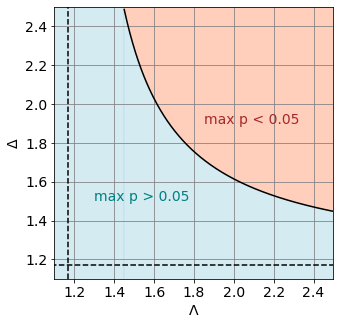

In [32]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1,1,figsize= (5,5))

plt.plot(x,y,color = 'black')
#plt.xticks([1,2,3,4,5])
plt.yticks([1.2,1.4,1.6,1.8,2,2.2,2.4])
plt.xticks([1.2,1.4,1.6,1.8,2,2.2,2.4])


plt.xlabel('Λ')
plt.ylabel('Δ')

plt.text(1.3,1.5,'max p > 0.05', color = 'teal')
plt.text(1.85,1.9,'max p < 0.05', color = 'brown')


plt.grid(True, color = 'gray')

plt.xlim([1.1,2.5])
plt.ylim([1.1,2.5])

plt.vlines(1.17,1.1,2.5, linestyle = '--')
plt.hlines(1.17,1,5, linestyle = '--')

plt.fill_between(x, y,10, alpha = 0.5,color = 'lightsalmon')

plt.fill_between(x, y, color = 'lightblue', alpha = 0.5)
plt.fill_between([1,1.44209],[5,5], color = 'lightblue', alpha = 0.5)

plt.savefig("rq1sens.pdf", bbox_inches='tight')

### d) Stratified by pre-treatment healthiness of focals

### 3 months

In [33]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [34]:
diff = []
Ns = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+4]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+4]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

clean_c_pre = [i for cnt,i in enumerate(c_pre) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_pre = [i for cnt,i in enumerate(t_pre) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_c_post = [i for cnt,i in enumerate(c_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_post = [i for cnt,i in enumerate(t_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]

c_pre = clean_c_pre
t_pre = clean_t_pre
t_post = clean_t_post
c_post = clean_c_post




In [35]:
#the difference, statified by initial scores

average_initial_score = []

for i in range(len(t_pre)):
    average_initial_score.append((t_pre[i]+c_pre[i])/2)

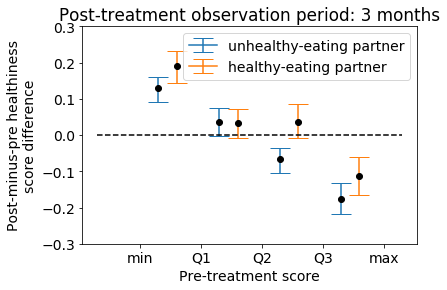

In [37]:
bins_initial_average = [-1,-0.21,-.04,0.05,1]


for i in range(len(bins_initial_average)-1):
    bin_h = []
    bin_l = []
    
    for j in range(len(average_initial_score)):
        if average_initial_score[j] >= bins_initial_average[i] and average_initial_score[j] < bins_initial_average[i+1]:
            bin_h.append(t_post[j] - t_pre[j])
            bin_l.append(c_post[j] - c_pre[j])
            
    
    l_error = [np.mean(bin_l) - lower_error(bin_l)]
    u_error = [upper_error(bin_l) - np.mean(bin_l)]
    asymetric_error = [l_error, u_error]

    if i == 0:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:blue',
                   label = 'unhealthy-eating partner')
    else:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:blue',
                   )

    plt.plot([i],[np.mean(bin_l)] , ls = 'none', marker = 'o', color = 'black')


    l_error = [np.mean(bin_h) - lower_error(bin_h)]
    u_error = [upper_error(bin_h) - np.mean(bin_h)]
    asymetric_error = [l_error, u_error]
 
    if i == 0:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10,  color = 'tab:orange',
                   label = 'healthy-eating partner')
    else:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10,  color = 'tab:orange',
                   )

    plt.plot([i+0.3],[np.mean(bin_h)] , ls = 'none', marker = 'o', color = 'black')
    




plt.xticks(np.array(range(len(bins_initial_average)))-0.3,['min','Q1','Q2','Q3','max'])

plt.xlabel('Pre-treatment score')
plt.ylabel('Post-minus-pre healthiness\nscore difference')
plt.legend()
plt.title('Post-treatment observation period: 3 months')

plt.ylim([-0.3,0.3])
plt.hlines(0,-1,4,linestyle = '--')
#plt.xlim([-0.5,3.5])


plt.savefig("rq1_1.pdf", bbox_inches='tight')

### 6 months

In [38]:
diff = []
Ns = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+7]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+7]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

clean_c_pre = [i for cnt,i in enumerate(c_pre) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_pre = [i for cnt,i in enumerate(t_pre) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_c_post = [i for cnt,i in enumerate(c_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_post = [i for cnt,i in enumerate(t_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]

c_pre = clean_c_pre
t_pre = clean_t_pre
t_post = clean_t_post
c_post = clean_c_post



In [39]:
#the difference, statified by initial scores

average_initial_score = []

for i in range(len(t_pre)):
    average_initial_score.append((t_pre[i]+c_pre[i])/2)

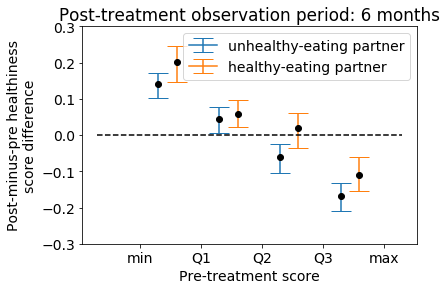

In [40]:
bins_initial_average = [-1,-0.21,-.04,0.05,1]


for i in range(len(bins_initial_average)-1):
    bin_h = []
    bin_l = []
    
    for j in range(len(average_initial_score)):
        if average_initial_score[j] >= bins_initial_average[i] and average_initial_score[j] < bins_initial_average[i+1]:
            bin_h.append(t_post[j] - t_pre[j])
            bin_l.append(c_post[j] - c_pre[j])
            
    
    l_error = [np.mean(bin_l) - lower_error(bin_l)]
    u_error = [upper_error(bin_l) - np.mean(bin_l)]
    asymetric_error = [l_error, u_error]

    if i == 0:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:blue',
                   label = 'unhealthy-eating partner')
    else:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:blue',
                   )

    plt.plot([i],[np.mean(bin_l)] , ls = 'none', marker = 'o', color = 'black')


    l_error = [np.mean(bin_h) - lower_error(bin_h)]
    u_error = [upper_error(bin_h) - np.mean(bin_h)]
    asymetric_error = [l_error, u_error]
 
    if i == 0:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:orange',
                   label = 'healthy-eating partner')
    else:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:orange',
                   )

    plt.plot([i+0.3],[np.mean(bin_h)] , ls = 'none', marker = 'o', color = 'black')
    




plt.xticks(np.array(range(len(bins_initial_average)))-0.3,['min','Q1','Q2','Q3','max'])

plt.xlabel('Pre-treatment score')
plt.ylabel('Post-minus-pre healthiness\nscore difference')
plt.legend()
plt.title('Post-treatment observation period: 6 months')
plt.ylim([-0.3,0.3])
plt.hlines(0,-1,4,linestyle = '--')
#plt.xlim([-0.5,3.5])

plt.savefig("rq1_2.pdf", bbox_inches='tight')

### 12 months

In [41]:
diff = []
Ns = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

Ns_c = []
Ns_t = []
for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+13]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+13]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
    Ns_t.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
    Ns_c.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["N"].iloc[0])
    
    
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

clean_c_pre = [i for cnt,i in enumerate(c_pre) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_pre = [i for cnt,i in enumerate(t_pre) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_c_post = [i for cnt,i in enumerate(c_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_t_post = [i for cnt,i in enumerate(t_post) if not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]

clean_partner_low = [i for cnt,i in enumerate(partner_low ) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_partner_high = [i for cnt,i in enumerate(partner_high ) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_Ns_t = [i for cnt,i in enumerate(Ns_t) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]
clean_Ns_c = [i for cnt,i in enumerate(Ns_c) if  not(np.isnan(c_pre[cnt])) and not(np.isnan(c_post[cnt])) and not(np.isnan(t_pre[cnt])) and not(np.isnan(t_post[cnt]))]

c_pre = clean_c_pre
t_pre = clean_t_pre
t_post = clean_t_post
c_post = clean_c_post

partner_low = clean_partner_low
partner_high = clean_partner_high
Ns_t = clean_Ns_t
Ns_c = clean_Ns_c




In [42]:
#the difference, statified by initial scores

average_initial_score = []

for i in range(len(t_pre)):
    average_initial_score.append((t_pre[i]+c_pre[i])/2)

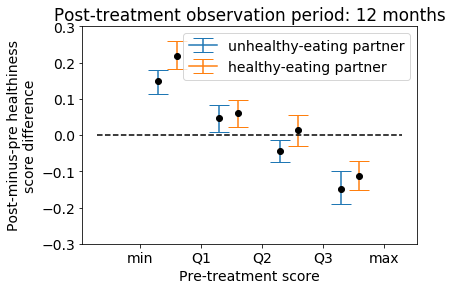

In [43]:
bins_initial_average = [-1,-0.21,-.04,0.05,1]


for i in range(len(bins_initial_average)-1):
    bin_h = []
    bin_l = []
    
    for j in range(len(average_initial_score)):
        if average_initial_score[j] >= bins_initial_average[i] and average_initial_score[j] < bins_initial_average[i+1]:
            bin_h.append(t_post[j] - t_pre[j])
            bin_l.append(c_post[j] - c_pre[j])
            
    
    l_error = [np.mean(bin_l) - lower_error(bin_l)]
    u_error = [upper_error(bin_l) - np.mean(bin_l)]
    asymetric_error = [l_error, u_error]

    if i == 0:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10,  color = 'tab:blue',
                   label = 'unhealthy-eating partner')
    else:
        plt.errorbar([i],
                   [np.mean(bin_l) ],
                   yerr = asymetric_error, capsize=10, color = 'tab:blue',
                   )

    plt.plot([i],[np.mean(bin_l)] , ls = 'none', marker = 'o', color = 'black')


    l_error = [np.mean(bin_h) - lower_error(bin_h)]
    u_error = [upper_error(bin_h) - np.mean(bin_h)]
    asymetric_error = [l_error, u_error]
 
    if i == 0:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10,  color = 'tab:orange',
                   label = 'healthy-eating partner')
    else:
        plt.errorbar([i+0.3],
                   [np.mean(bin_h) ],
                   yerr = asymetric_error, capsize=10,  color = 'tab:orange',
                   )

    plt.plot([i+0.3],[np.mean(bin_h)] , ls = 'none', marker = 'o', color = 'black')
    




plt.xticks(np.array(range(len(bins_initial_average)))-0.3,['min','Q1','Q2','Q3','max'])

plt.xlabel('Pre-treatment score')
plt.ylabel('Post-minus-pre healthiness\nscore difference')
plt.legend()
plt.title('Post-treatment observation period: 12 months')


plt.ylim([-0.3,0.3])
plt.hlines(0,-1,4,linestyle = '--')
#plt.xlim([-0.5,3.5])

plt.savefig("rq1_3.pdf", bbox_inches='tight')